# Mining travel patterns of urban residents based on origin-destination mobility data
[Github link](https://github.com/CeHouGIS/dsss_finalwork)

## 1. Introduction

Travel pattern refers to a periodic travel behaviour formed by human mobility in geographical space (Kitamura, 2001). Many behaviours can reflect the travel pattern in the city, such as commute trips (Chakrabarti, 2017). Urban travel pattern is crucial to understanding the urban residents’ demand for urban resources, hence improving the location-based services (Phithakkitnukoon et al., 2010; Kumar et al., 2016; Demissie et al., 2021), assisting urban planning and optimizing transportation resource distribution (Guo et al., 2012). In addition, urban travel patterns can also help governments identify inequalities in the resources distribution in cities (Mahadevia and Advani, 2016).

The rise of location-aware technologies makes human mobility in the urban area more sensible. GPS technology and smartcards provide massive data with high spatio-temporal resolution and play a huge role in analyzing the mobility of urban dwellers, such as understanding individual travel behaviours (Ma et al., 2013); passenger group classification; travel purpose survey (Chu and Chapleau, 2010; Lee and Hickman, 2014), etc.

This article aims to investigate the travel pattern of urban residents based on origin-destination mobility data and try to analyse their different features according to the land use type. New York City (NYC) is used as a case study. 

The remainder of this article is organised as follows. Section 2 talks about related works about extracting AOIs and trajectory data. Section 3 talks about the research question; Section 4 shows the data used in this article. Section 5 illustrates the methodology for case study. Section 6 and Section 7 are the results and conclusion. 

***

## 2. Literature review 
### 2.1 Data for human mobility analysis

Decades ago, most researchers actively collected data for human mobility analysis, such as filling out questionnaires or requiring subjects to carry GPS receivers and record data (Asakura and Iryo, 2007; Du and Aultman-Hall, 2007; Stopher, FitzGerald and Zhang, 2008; Gao et al., 2013). Since all these data need to be actively collected, the amount of data is usually small. Innovations in location-aware technologies have changed the way we explore mobility active exploration to data-driven modelling. Data produced by location-aware technologies are characterized by large data volume and high spatial-temporal resolution. Lots of research are conducted and mined more accurate travel patterns by using GNSS trajectory data (Giannotti et al., 2011; Xia et al., 2018; Wang et al., 2020), smartcard data  (El Mahrsi et al., 2017; Zhao, Koutsopoulos and Zhao, 2018) and smartphone signalling data (Song et al., 2020). 


### 2.2 Mobility patterns exploration

The clustering method is the mainstream method for studying urban spatio-temporal mobility patterns. Clustering is an ideal tool for mining travel patterns because it can capture data similarities in the space. Guo et al. (2012) used K-means to discover the spatial mobility pattern in Shenzhen. Density-based clustering method, such as DBSCAN, is initially used for handling trajectory data (Tang et al., 2015; Kumar et al., 2016) but is also applied to analyse the taxi OD data (J. Chen et al., 2020; Zheng et al., 2018; Zhang et al., 2016; Wang, Wang and Li, 2006). Network analysis is another popular way to capture mobility patterns in urban areas (Guo, Liu and Jin, 2010; Gao et al., 2013). Nowadays, the deep learning method is also applied to capture the travel pattern for human ability with good results. Wang, Currim and Ram (2022) use CNN to predict the traffic spatio-temporal patterns for urban mobility; Chu, Lam and Li (2020) use Long short term memory (LSTM) to predict the travel demand in the urban area. 

***

## 3. Research question 
The exact research question of this article is that:

**What are the different travel patterns of urban dwellers? And what is the relationship between land use and travel patterns?**

In this article, used Python libraries are listed as follows:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns
import time
import datetime
from scipy.spatial import ConvexHull
from shapely.geometry import Point,Polygon
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable

# clustering
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import KMeans, DBSCAN, OPTICS, AgglomerativeClustering
from sklearn.neighbors import NearestNeighbors
import st_dbscan

# PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split

# classification
from sklearn.feature_extraction import DictVectorizer
from sklearn.neural_network import MLPClassifier
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings("ignore")


***
## 4. Presentation of data 
In this article, two datasets are used to capture the similarity of urban travel:
1. [TLC Trip Record Data](https://www1.nyc.gov/site/tlc/about/fact-book.page): New York City Taxi and Limousine Commission (TLC) has collected a wealth of data about taxi’s precise take-up and drop-off location and related information from 2009 to now. After 2016, under the consideration of privacy protection, TLC used taxi zone instead of precise coordinates. Pick-up and drop-off time, taxi zone,  travel record, distance, total cost, and passengers number are used to describe every travel record.

2. [Primary Land Use Tax Lot Output (PLUTO)](https://www1.nyc.gov/site/planning/data-maps/open-data/dwn-pluto-mappluto.page ): PLUTO data contains lots of land use and geographic data at the tax lot level, which is collected by Department of City Planning (DCP).

In this article, the origin-destination (OD) flow of yellow taxis in Jan 2021 (a totally of 1,369,765 travel records) is used to analyse the spatio-temporal similarity of travel records. Due to space limitations, only pick-up points are analysed in this paper.

In the PLUTO dataset, zoning district and land use category, together with the coordinate are collected to analyse the built environment feature in the AOIs. The description of these two variables are as follows:

1. zoning district: The map of New York City is generally apportioned into three basic zoning district categories: Residence (R), Commercial (C), Manufacturing (M), Battery Park City (B) and Public Places (P).which are further divided into a range of individual zoning districts, denoted by different number and letter combinations. In general, the higher the number immediately following the first letter (R, C, M, B and P), the higher the density or intensity of land use permitted.

2. land use category: The Department of City Planning has created 11 land use categories and assigns each
BUILDING CLASS to the most appropriate land use category. detailed information are in Appendix. A.


In [2]:
# import pluto data
pluto_path = r'./dataset/nyc_pluto_21v4_csv/pluto_21v4.csv'
pluto = pd.read_csv(pluto_path)

# import taxi zone
taxi_zone_path = r'./dataset/taxi_zones/taxi_zones.shp'
taxi_zone = gpd.read_file(taxi_zone_path)

# import taxi data
taxi_data = pd.read_csv(r'./dataset/taxidata/yellow_tripdata_2021-01.csv')

print(f'data name: taxi zones, contains {taxi_zone.shape[0]} areas')
print(f'data name: PLUTO data, contains {pluto.shape[0]} records, {pluto.shape[1]} variables')
print(f'data name: TLC trip record data, contains {taxi_data.shape[0]} records, {taxi_data.shape[1]} variables')

data name: taxi zones, contains 263 areas
data name: PLUTO data, contains 859032 records, 92 variables
data name: TLC trip record data, contains 1369765 records, 18 variables


In [3]:
taxi_data.head()

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0       1.0  2021-01-01 00:30:10   2021-01-01 00:36:12              1.0   
1       1.0  2021-01-01 00:51:20   2021-01-01 00:52:19              1.0   
2       1.0  2021-01-01 00:43:30   2021-01-01 01:11:06              1.0   
3       1.0  2021-01-01 00:15:48   2021-01-01 00:31:01              0.0   
4       2.0  2021-01-01 00:31:49   2021-01-01 00:48:21              1.0   

   trip_distance  RatecodeID store_and_fwd_flag  PULocationID  DOLocationID  \
0           2.10         1.0                  N           142            43   
1           0.20         1.0                  N           238           151   
2          14.70         1.0                  N           132           165   
3          10.60         1.0                  N           138           132   
4           4.94         1.0                  N            68            33   

   payment_type  fare_amount  extra  mta_tax  tip_amount  tolls_amount  \
0           2.0          8.0    3.0      0.5        0.00           0.0   
1           2.0          3.0    0.5      0.5        0.00           0.0   
2           1.0         42.0    0.5      0.5        8.65           0.0   
3           1.0         29.0    0.5      0.5        6.05           0.0   
4           1.0         16.5    0.5      0.5        4.06           0.0   

   improvement_surcharge  total_amount  congestion_surcharge  
0                    0.3         11.80                   2.5  
1                    0.3          4.30                   0.0  
2                    0.3         51.95                   0.0  
3                    0.3         36.35                   0.0  
4                    0.3         24.36                   2.5

### 4.1 Data preprocess

The TLC trip record data contained many records which was recorded incorrectly, and some records whose travel distance is too short. Plus, the PLUTO data contained too many variables that were not involved in this analysis; we took some measures to clean these data before starting the experiment:
1. drop the TLC trip record data whose distance is `NaN` or under 0.5 kilometres.
2. drop the TLC trip record data that contains `NaN` or below zero in ` passenger_count` and ` total_amount`.
3. Drop the PLUTO data whose location is beyond the research area (NYC).
4. Transform the over-detailed description in `zonedist1` into a more general classification, and convert `zonedist1` and ` landuse` into dummy variables.

In [4]:
# data cleaning in TLC trip record data
taxi_data_pickup = taxi_data[['tpep_pickup_datetime','PULocationID','passenger_count','trip_distance','total_amount']]
taxi_data_pickup = taxi_data_pickup[taxi_data_pickup['passenger_count'] > 0]
taxi_data_pickup = taxi_data_pickup[taxi_data_pickup['trip_distance'] > 0.5]
taxi_data_pickup = taxi_data_pickup[taxi_data_pickup['total_amount'] > 0]
hour = pd.DataFrame()
hour['hour'] = taxi_data_pickup['tpep_pickup_datetime'].apply((lambda x: int(x[11:13])))
taxi_data_pickup = taxi_data_pickup.join(hour)

print(f'{taxi_data_pickup.shape[0]} records are valid for the pick-up points.')

1157331 records are valid for the pick-up points.


In [5]:
taxi_data_pickup = taxi_data_pickup.merge(taxi_zone[['LocationID','borough','geometry']],how='inner',left_on='PULocationID', right_on='LocationID')

pickup_time_ls = []
pickup_time_group = taxi_data_pickup.groupby('hour')

for unit in pickup_time_group:
    pickup_time_ls.append(unit[1])

Fig. 1 and Fig. 2 show the temporal and spatial distribution of pick-up and drop-off points in New York City separately:

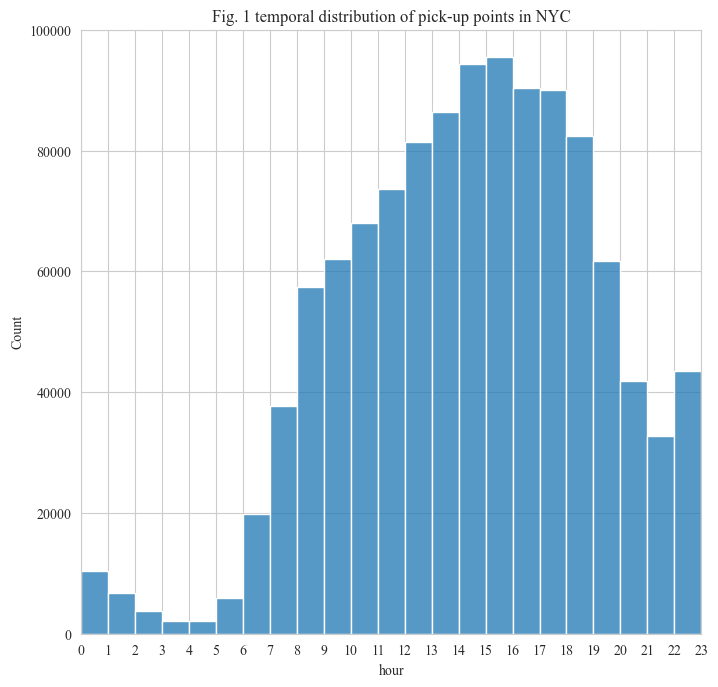

In [6]:
# histogram of pickup and dropoff
sns.set_style("whitegrid")
plt.rcParams['font.sans-serif'] = 'Times New Roman'
fig,axes = plt.subplots(figsize=(8,8),dpi=100)
sns.histplot( data=taxi_data_pickup, x='hour' ,binwidth=1)

axes.set_title('Fig. 1 temporal distribution of pick-up points in NYC')
axes.set_xlim(0,23)
axes.set_ylim(0,100000)
axes.xaxis.set_major_locator(ticker.MultipleLocator(1))
plt.show()

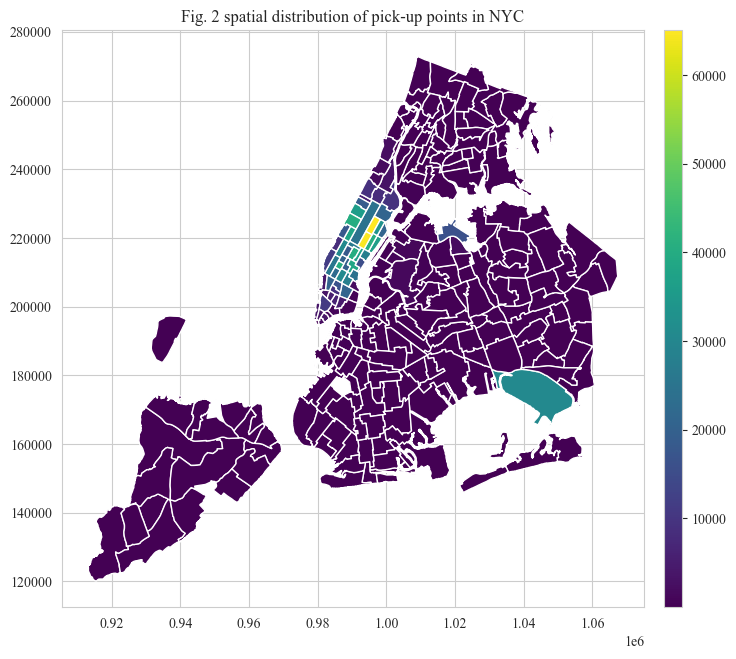

In [7]:
taxi_data_pu_group = taxi_data_pickup.groupby('PULocationID')

# get taxi trip records count by PULocationID
taxi_data_pu_sum = pd.DataFrame()
taxi_data_do_sum = pd.DataFrame()

for unit in taxi_data_pu_group:
    tem_df = pd.DataFrame({
        'zone_id':[unit[1].iloc[0,1]],        
        'mean_distance':[unit[1]['trip_distance'].mean()],
        'mean_passenger_count':[unit[1]['passenger_count'].mean()],
        'mean_fare':[unit[1]['total_amount'].mean()],
        'count':[unit[1]['total_amount'].count()],
        'geometry':[unit[1].iloc[0,-1]]
    })
    taxi_data_pu_sum = taxi_data_pu_sum.append(tem_df)
    
taxi_data_pu_sum = gpd.GeoDataFrame(taxi_data_pu_sum)

# plot
fig,ax = plt.subplots(figsize=(8,8),dpi=100)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
taxi_data_pu_sum.plot(column='count',ax=ax,cmap='viridis', legend=True, cax=cax)
ax.set_title('Fig. 2 spatial distribution of pick-up points in NYC')

plt.show()    

For the time distribution, there is an apparent low-frequency time range from 0 a.m. to 6:00 a.m. and very active from 2 p.m. to 7 p.m. 

Fig. 2 shows the spatial distribution of pick-up points in NYC. Manhattan district is the apparent hotspot area. In addition, some essential transportation centres also have a very high amount of pick-up records, such as John F. Kennedy International Airport and LaGuardia Airport.

In [8]:
# data preprocess for PLUTO data
variables = ['latitude','longitude','zonedist1','landuse',]
pluto = pluto[variables]
pluto = pluto[(pluto['latitude'] > 0)]
pluto = pluto.dropna(how = 'any')
pluto.head()

latitude  longitude zonedist1  landuse
0  40.733326 -73.991972      C6-1      2.0
1  40.597676 -73.964833        R5      1.0
2  40.593135 -73.969560        R4      1.0
3  40.715699 -73.803864       R4B      1.0
4  40.725978 -73.723547       R2A      1.0

In [9]:
pluto.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 854556 entries, 0 to 859029
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   latitude   854556 non-null  float64
 1   longitude  854556 non-null  float64
 2   zonedist1  854556 non-null  object 
 3   landuse    854556 non-null  float64
dtypes: float64(3), object(1)
memory usage: 32.6+ MB


In [10]:
pluto['zonedist1_short'] = pluto['zonedist1'].apply((lambda x: x[0]))

pluto.head()

latitude  longitude zonedist1  landuse zonedist1_short
0  40.733326 -73.991972      C6-1      2.0               C
1  40.597676 -73.964833        R5      1.0               R
2  40.593135 -73.969560        R4      1.0               R
3  40.715699 -73.803864       R4B      1.0               R
4  40.725978 -73.723547       R2A      1.0               R

Fig. 3. shows the spatial distribution of PLUTO data in New York City, which covers almost all areas of the city with high urban activity.

<Figure size 600x400 with 0 Axes>

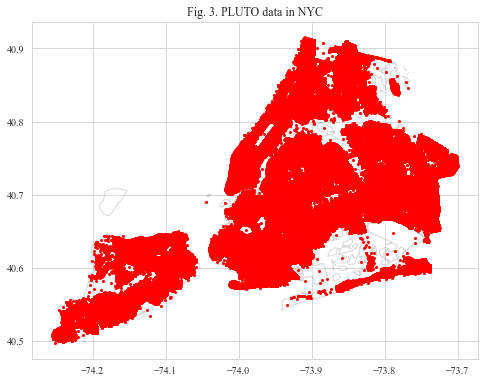

In [11]:
taxi_zone = taxi_zone.to_crs(epsg=4326)

plt.figure(dpi=100)
ax = taxi_zone.plot(alpha=0.3,ec="#808080",fc="#ffffff",figsize=(8,8))
pluto_gdf = gpd.GeoDataFrame(
    pluto, geometry=gpd.points_from_xy( pluto['longitude'], pluto['latitude']))

pluto_gdf.plot(ax=ax,color='red',markersize=4,column='hour',legend = True)
plt.title('Fig. 3. PLUTO data in NYC')
plt.show()

In [12]:
# join taxi zone data with pluto data
taxi_zone_with_pluto = pluto_gdf.sjoin(taxi_zone, how="inner")
# transfer dataframe into dictionary
taxi_zone_with_pluto.head()

latitude  longitude zonedist1  landuse zonedist1_short  \
0     40.733326 -73.991972      C6-1      2.0               C   
238   40.733899 -73.994136      R7-2      3.0               R   
1163  40.734031 -73.998171        R6      2.0               R   
2190  40.727919 -73.992647     M1-5B      5.0               M   
2369  40.736589 -73.996172      C6-2      8.0               C   

                        geometry  index_right  OBJECTID  Shape_Leng  \
0     POINT (-73.99197 40.73333)          112       113    0.032745   
238   POINT (-73.99414 40.73390)          112       113    0.032745   
1163  POINT (-73.99817 40.73403)          112       113    0.032745   
2190  POINT (-73.99265 40.72792)          112       113    0.032745   
2369  POINT (-73.99617 40.73659)          112       113    0.032745   

      Shape_Area                     zone  LocationID    borough  
0       0.000058  Greenwich Village North         113  Manhattan  
238     0.000058  Greenwich Village North         113  Manhattan  
1163    0.000058  Greenwich Village North         113  Manhattan  
2190    0.000058  Greenwich Village North         113  Manhattan  
2369    0.000058  Greenwich Village North         113  Manhattan

In [13]:
landuse = taxi_zone_with_pluto[['borough','zonedist1_short','LocationID']]
landuse_group = landuse.groupby('LocationID')

We have to prove that PLUTO data can describe the land use condition where travel records appear. To achieve that, we calculate the coverage of PLUTO data in taxi zones and the coverage of areas through which taxi travel records occur.

In [14]:
pluto_cover_area = len(taxi_zone_with_pluto.value_counts('LocationID'))
taxi_cover_area = len(taxi_data_pu_sum)

# test how many taxi records are included 
intersect = taxi_zone_with_pluto.merge(taxi_data_pu_sum,how='inner',left_on='LocationID',right_on='zone_id')
intersaction_num = len(intersect.value_counts('LocationID'))

cover_records_rate = intersect[['zone_id','count']].drop_duplicates()['count'].sum() / taxi_data_pu_sum['count'].sum()
print(f'PLUTO data covers {pluto_cover_area} zones')
print(f'TLC taxi trip record data covers {taxi_cover_area} zones')
print(f'cover rate of taxi zones:{(intersaction_num / taxi_cover_area):.02f}, cover rate of travel records: {cover_records_rate:.02f}')

PLUTO data covers 259 zones
TLC taxi trip record data covers 252 zones
cover rate of taxi zones:1.00, cover rate of travel records: 1.00


The result shows that all the taxi zones that appeared in TLC taxi trip record data are covered by PLUTO data, and all of taxi data are included. This result proves that PLUTO data can analyse the land use condition of the places where taxi trip data is covered.

***
## 5. Methodology 

We design two-stage work to capture the spatio-temporal similarity and analysis the land use factors separately. 

The first stage uses the clustering method to capture the similarity of taxi travel records. The anonymized data limits us from directly using the coordinate to investigate the spatial similarities. Thus, we create a set of vectors containing passenger count, travel distance, and travel cost to represent a travel record and summarise the travel patterns of all passengers within the taxi zone by averaging those features. Meanwhile, to keep the temporal features of the data, we split the original data into 24 parts by hour. Then, K-means and DBSCAN analyse the mean distance and cost. K-means generate clusters by measuring the travel vector to the gravity centre; DBSCAN is a density-based clustering method that generates clusters based on vectors' gathering (Ram et al., 2010). After that, hierarchical clustering is used to discover the similarity of temporal distribution in one day.

The second stage focus on the land use condition of clusters’ results. In order to understand why these travel patterns in this place are similar and what characteristics these clusters have, we label the land type of the taxi zones by using the PLUTO dataset, then investigate the composition of land use to compare the difference in clustering results.
***
## 6. Results and discussion
### 6.1 Descriptive result
Fig. 4. shows the count of travel records in NYC, divided by hours:

In [15]:
pickup_sum_bytime_ls = []
for i in range(len(pickup_time_ls)):
    pickup_zone_group = pickup_time_ls[i].groupby('PULocationID')

    # get taxi trip records count by PULocationID
    pickup_sum_bytime = pd.DataFrame()
    for unit in pickup_zone_group:
        tem_df = pd.DataFrame({
            'zone_id':[unit[1].iloc[0,1]],        
            'mean_distance':[unit[1]['trip_distance'].mean()],
            'mean_passenger_count':[unit[1]['passenger_count'].mean()],
            'mean_fare':[unit[1]['total_amount'].mean()],
            'count':[unit[1]['total_amount'].count()],
            # 'area':[unit[1].iloc[0,-1].area],
            # 'density':[unit[1]['total_amount'].count() / unit[1].iloc[0,-1].area],
            'geometry':[unit[1].iloc[0,-1]]
        })
        pickup_sum_bytime = pickup_sum_bytime.append(tem_df)
    pickup_sum_bytime_ls.append(pickup_sum_bytime)
    

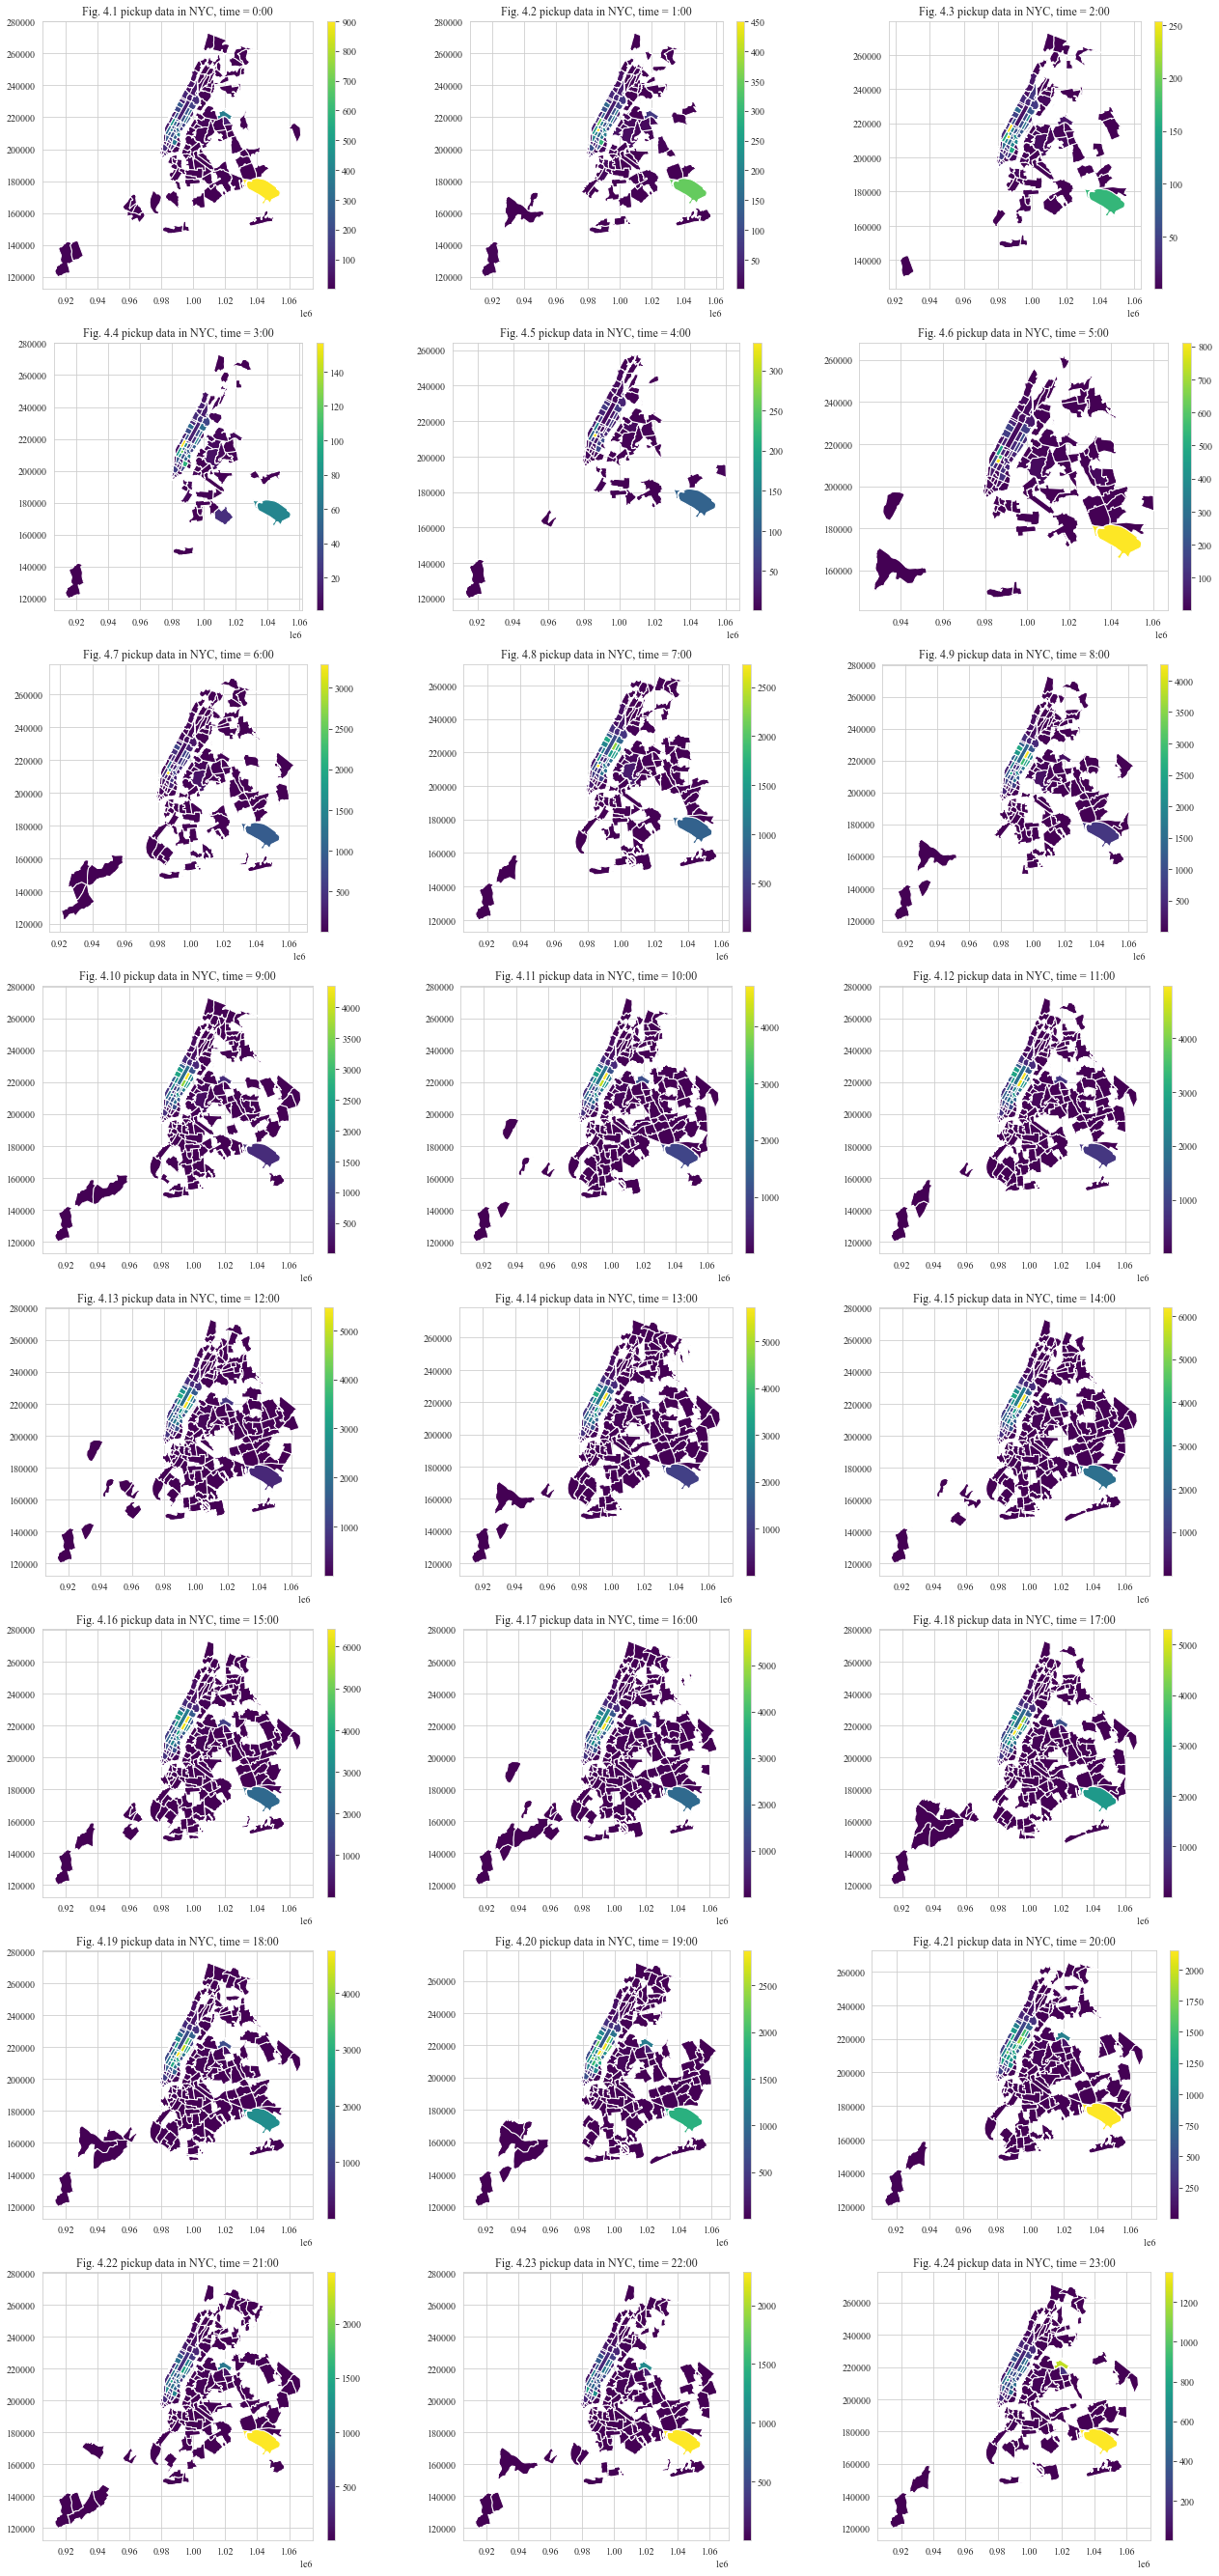

In [16]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig,axes = plt.subplots(8,3,figsize=(22,48))

for i in range(8):
    for j in range(3):
        pickup_sum_time = gpd.GeoDataFrame(pickup_sum_bytime_ls[3*i+j])
        axes[i,j].set_title(f'Fig. 4.{3*i+j+1} pickup data in NYC, time = {3*i+j}:00')
        divider = make_axes_locatable(axes[i,j])

        cax = divider.append_axes("right", size="3%", pad=0.2)
        pickup_sum_time.plot(column='count',cmap='viridis', ax=axes[i,j], legend=True, cax=cax)

plt.show()

There are several recognizable time and space hotspots on the map, whereas Manhattan, John F. Kennedy International Airport and LaGuardia Airport. JFK Airport become active at night (From 8 p.m. to 12 a.m.), and Manhattan is busier during the day (from 8 a.m. to 7 p.m.)

### 6.2 DBSCAN and K-means clustering
Determining the parameter of clustering methods is of vital importance. K-means need to set the number of clusters `n_clusters`; DBSCAN needs to determine the minimum points `MinPts` and `eps`, which specifies how close points should be to each other be considered a part of a cluster. Hierarchical clustering does not need to define any parameters. It only considers the distance between all the inputs. 

**Silhouette Coefficient** is the metric we used to evaluate a clustering result. The silhouette Coefficient changes from -1 to 1, and a higher silhouette coefficient indicates a better clustering result.

The elbow method can determine both `n_clusters` in K-means and `eps` in DBSCAN. There is no good way to find the best `MinPts`. In this article, we decide on the `MinPts` by increasing the `MinPts` and finding the result with the highest Silhouette Coefficient.

In [17]:
def data_norm(taxi_pu_data):
    '''
    normalization
    '''
    taxi_pu_data['mean_distance'] = (taxi_pu_data['mean_distance'] - taxi_pu_data['mean_distance'].min()) / (taxi_pu_data['mean_distance'].max() - taxi_pu_data['mean_distance'].min())
    taxi_pu_data['mean_fare'] = (taxi_pu_data['mean_fare'] - taxi_pu_data['mean_fare'].min()) / (taxi_pu_data['mean_fare'].max() - taxi_pu_data['mean_fare'].min())
    taxi_pu_data['mean_passenger_count'] = (taxi_pu_data['mean_passenger_count'] - taxi_pu_data['mean_passenger_count'].min()) / (taxi_pu_data['mean_passenger_count'].max() - taxi_pu_data['mean_passenger_count'].min())
    return taxi_pu_data

In [18]:
def find_eps(distances):
    '''
    find the optimal eps based on the Maximum value of derivative
    '''
    dy_distances = []
    for i in range(1,len(distances)):
        tem = distances[i] - distances[i-1]
        dy_distances.append(tem)

    idx = dy_distances.index(max(dy_distances)) - 10
    return distances[idx]

def do_dbscan(df,minPts,epsilon):
    dbsc = DBSCAN(eps=epsilon, min_samples=minPts)
    dbsc.fit(df)
    return dbsc.labels_

In [19]:
# elbow method for DBSCAN and K-means
plt.figure(figsize=(8,8))
best_eps = []

for i in range(len(pickup_sum_bytime_ls)):
# calculate distance
    neigh_pickup = NearestNeighbors(n_neighbors=2)
    nbrs_pickup = neigh_pickup.fit(pickup_sum_bytime_ls[i][['mean_distance','mean_fare','mean_passenger_count']])
    
    distances_pickup, indices_pickup = nbrs_pickup.kneighbors(pickup_sum_bytime_ls[i][['mean_distance','mean_fare','mean_passenger_count']])
    distances_pickup = np.sort(distances_pickup[:,1]) 
    eps = find_eps(distances_pickup)
    best_eps.append(eps)
    

<Figure size 576x576 with 0 Axes>

In [20]:
# find the optimal minpts

best_minpts = []
for i in range(len(pickup_sum_bytime_ls)):
    dbs_score = []
    pickup_dbs = pickup_sum_bytime_ls[i][['mean_distance','mean_fare','mean_passenger_count']]
    # pickup_dbs = data_norm(pickup_dbs)
    for j in range(20):    
        cluster_nm = do_dbscan(pickup_dbs,j,best_eps[i])
        dbs_score.append(metrics.silhouette_score(pickup_dbs, cluster_nm))

    best_minpts.append(dbs_score.index(max(dbs_score)))
    print(f'the max silhouette score is {max(dbs_score):.02f}, MinPts = {dbs_score.index(max(dbs_score))}')

the max silhouette score is 0.75, MinPts = 6
the max silhouette score is 0.78, MinPts = 5
the max silhouette score is 0.72, MinPts = 6
the max silhouette score is 0.37, MinPts = 7
the max silhouette score is 0.69, MinPts = 4
the max silhouette score is 0.73, MinPts = 5
the max silhouette score is 0.55, MinPts = 0
the max silhouette score is 0.65, MinPts = 8
the max silhouette score is 0.73, MinPts = 6
the max silhouette score is 0.75, MinPts = 6
the max silhouette score is 0.64, MinPts = 11
the max silhouette score is 0.68, MinPts = 11
the max silhouette score is 0.74, MinPts = 4
the max silhouette score is 0.68, MinPts = 9
the max silhouette score is 0.66, MinPts = 11
the max silhouette score is 0.62, MinPts = 6
the max silhouette score is 0.71, MinPts = 5
the max silhouette score is 0.60, MinPts = 9
the max silhouette score is 0.67, MinPts = 9
the max silhouette score is 0.71, MinPts = 11
the max silhouette score is 0.66, MinPts = 11
the max silhouette score is 0.65, MinPts = 13
the 

DBSCAN's result are displayed as follows:

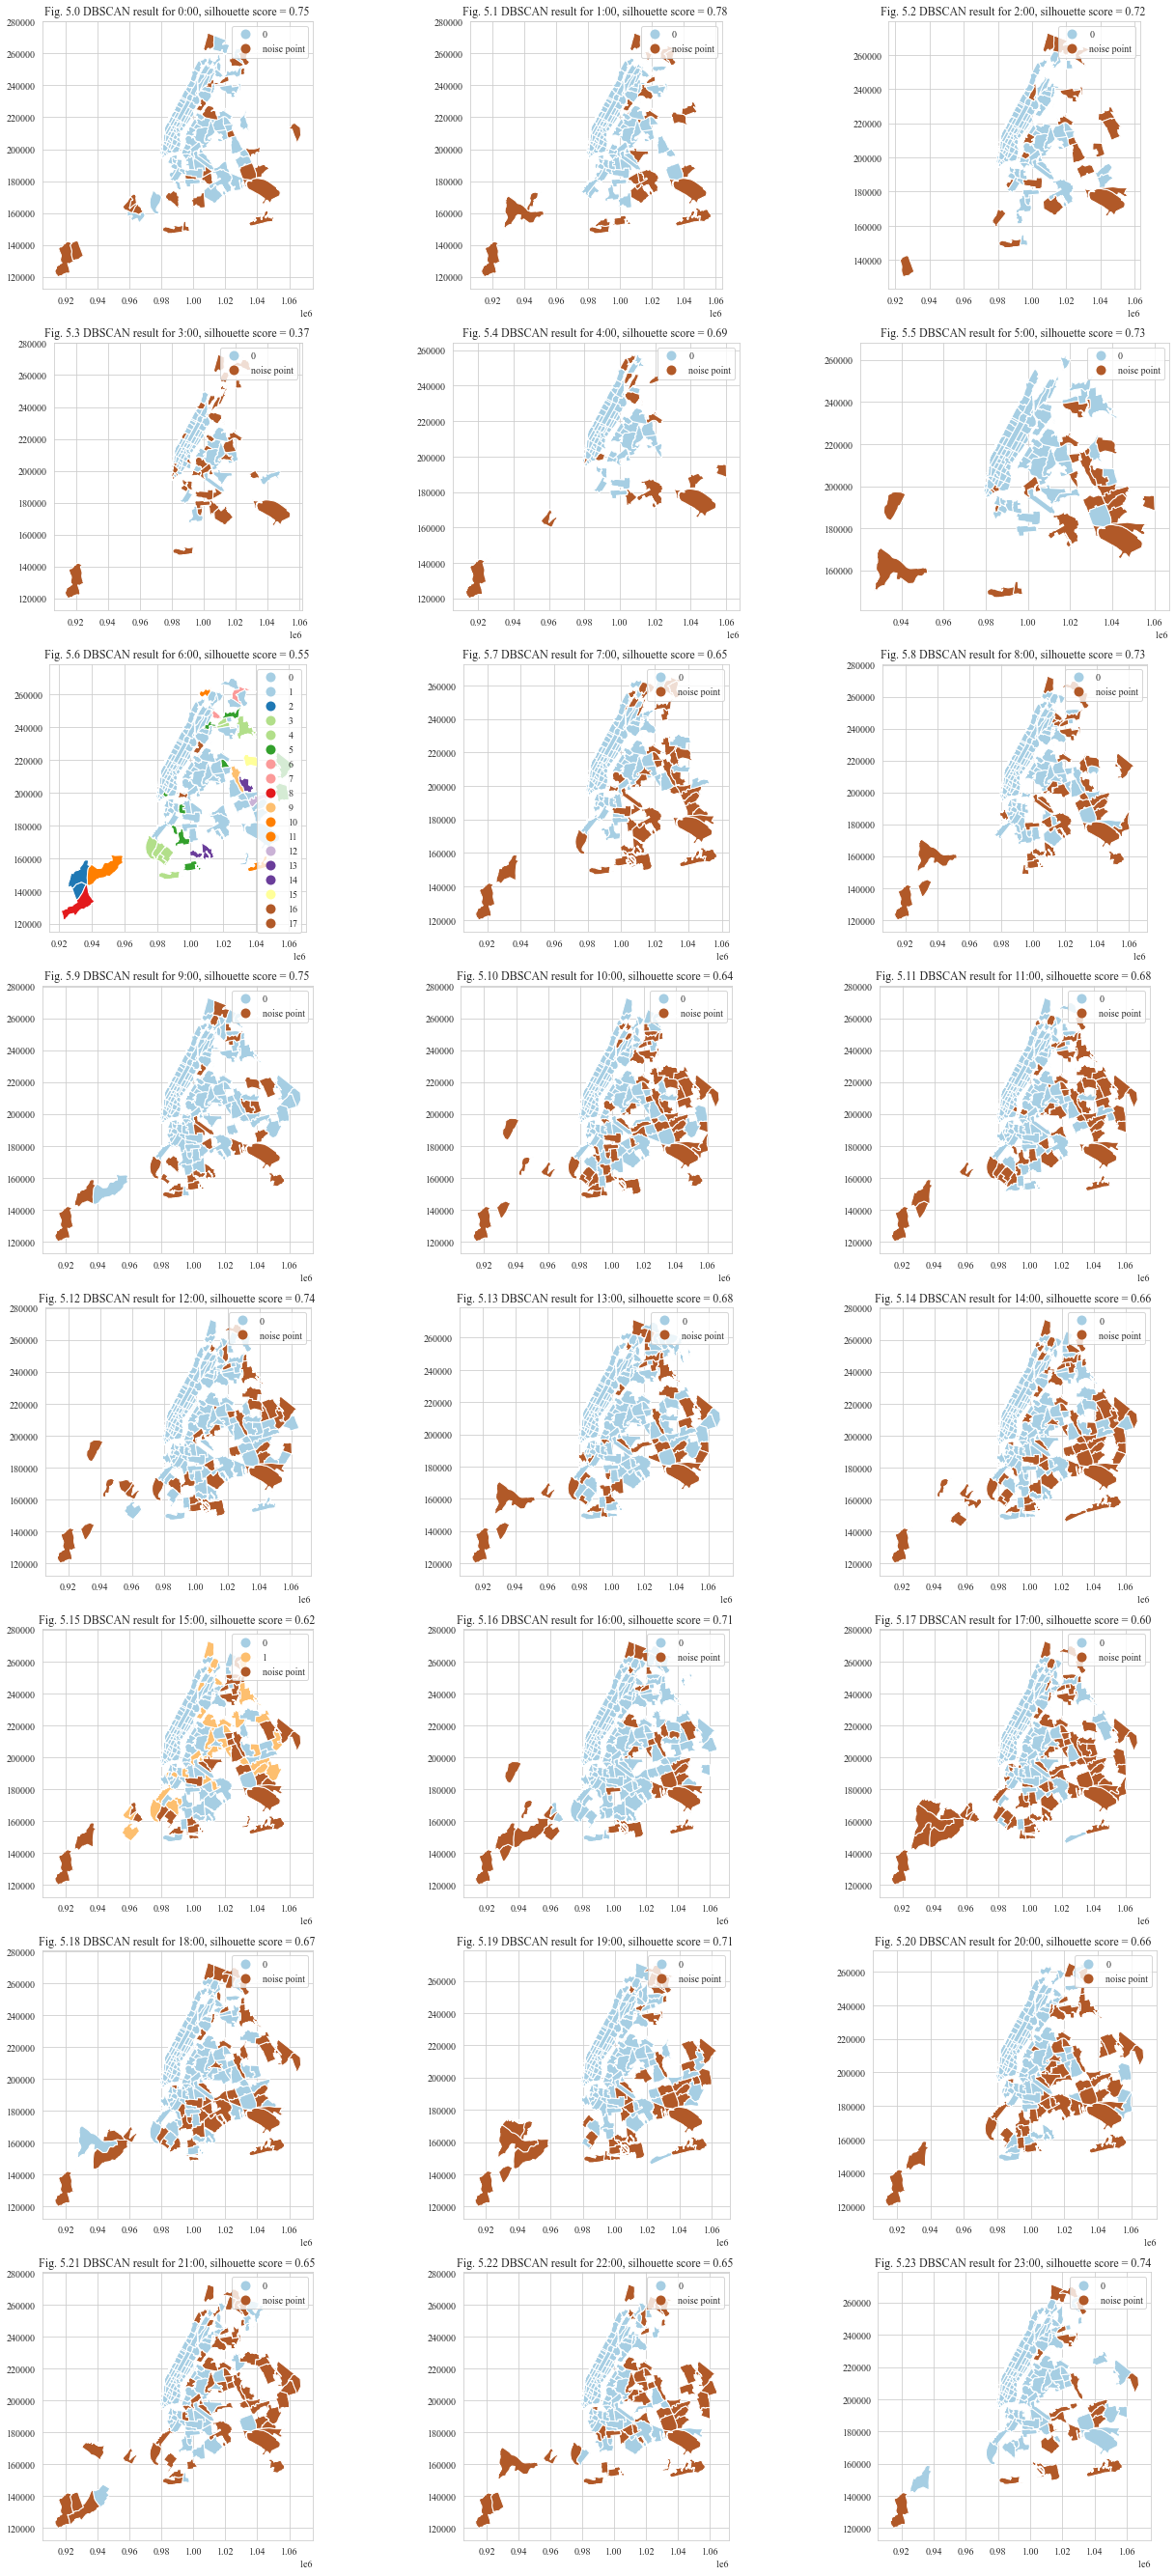

In [21]:
# dbscan
fig, ax = plt.subplots(8,3,figsize=(22,48))
# We now have our DBSCAN object created, and we can extract the groups it has identified. We do this using the `.labels_` method.
for i in range(8):
    for j in range(3):
        pickup_data = pickup_sum_bytime_ls[3*i+j][['mean_distance','mean_fare','mean_passenger_count']]
        # pickup_dbs = data_norm(pickup_dbs)
        cluster_nm = do_dbscan(pickup_data,best_minpts[3*i+j],best_eps[3*i+j])

        gdf = gpd.GeoDataFrame(pickup_sum_bytime_ls[3*i+j])
        gdf['cluster_nm'] = cluster_nm
        gdf['cluster_nm'] = gdf['cluster_nm'].replace(-1,'noise point')
        gdf.plot(column='cluster_nm', categorical=True, legend=True, figsize=(12,8),ax=ax[i,j], cmap='Paired')
        ax[i,j].set_title(f'Fig. 5.{3*i+j} DBSCAN result for {3*i+j}:00, silhouette score = {metrics.silhouette_score(pickup_data, cluster_nm):.02f} ')

Fig. 5. shows that, in most scenarios, DBSCAN can only detect one cluster, which contains the central part of Manhattan and some parts of Bronx, Brooklyn, and Queens. There seems to have some error in the 6 a.m. scenario. 

Fig. 6. shows the elbow method's result for K-means:

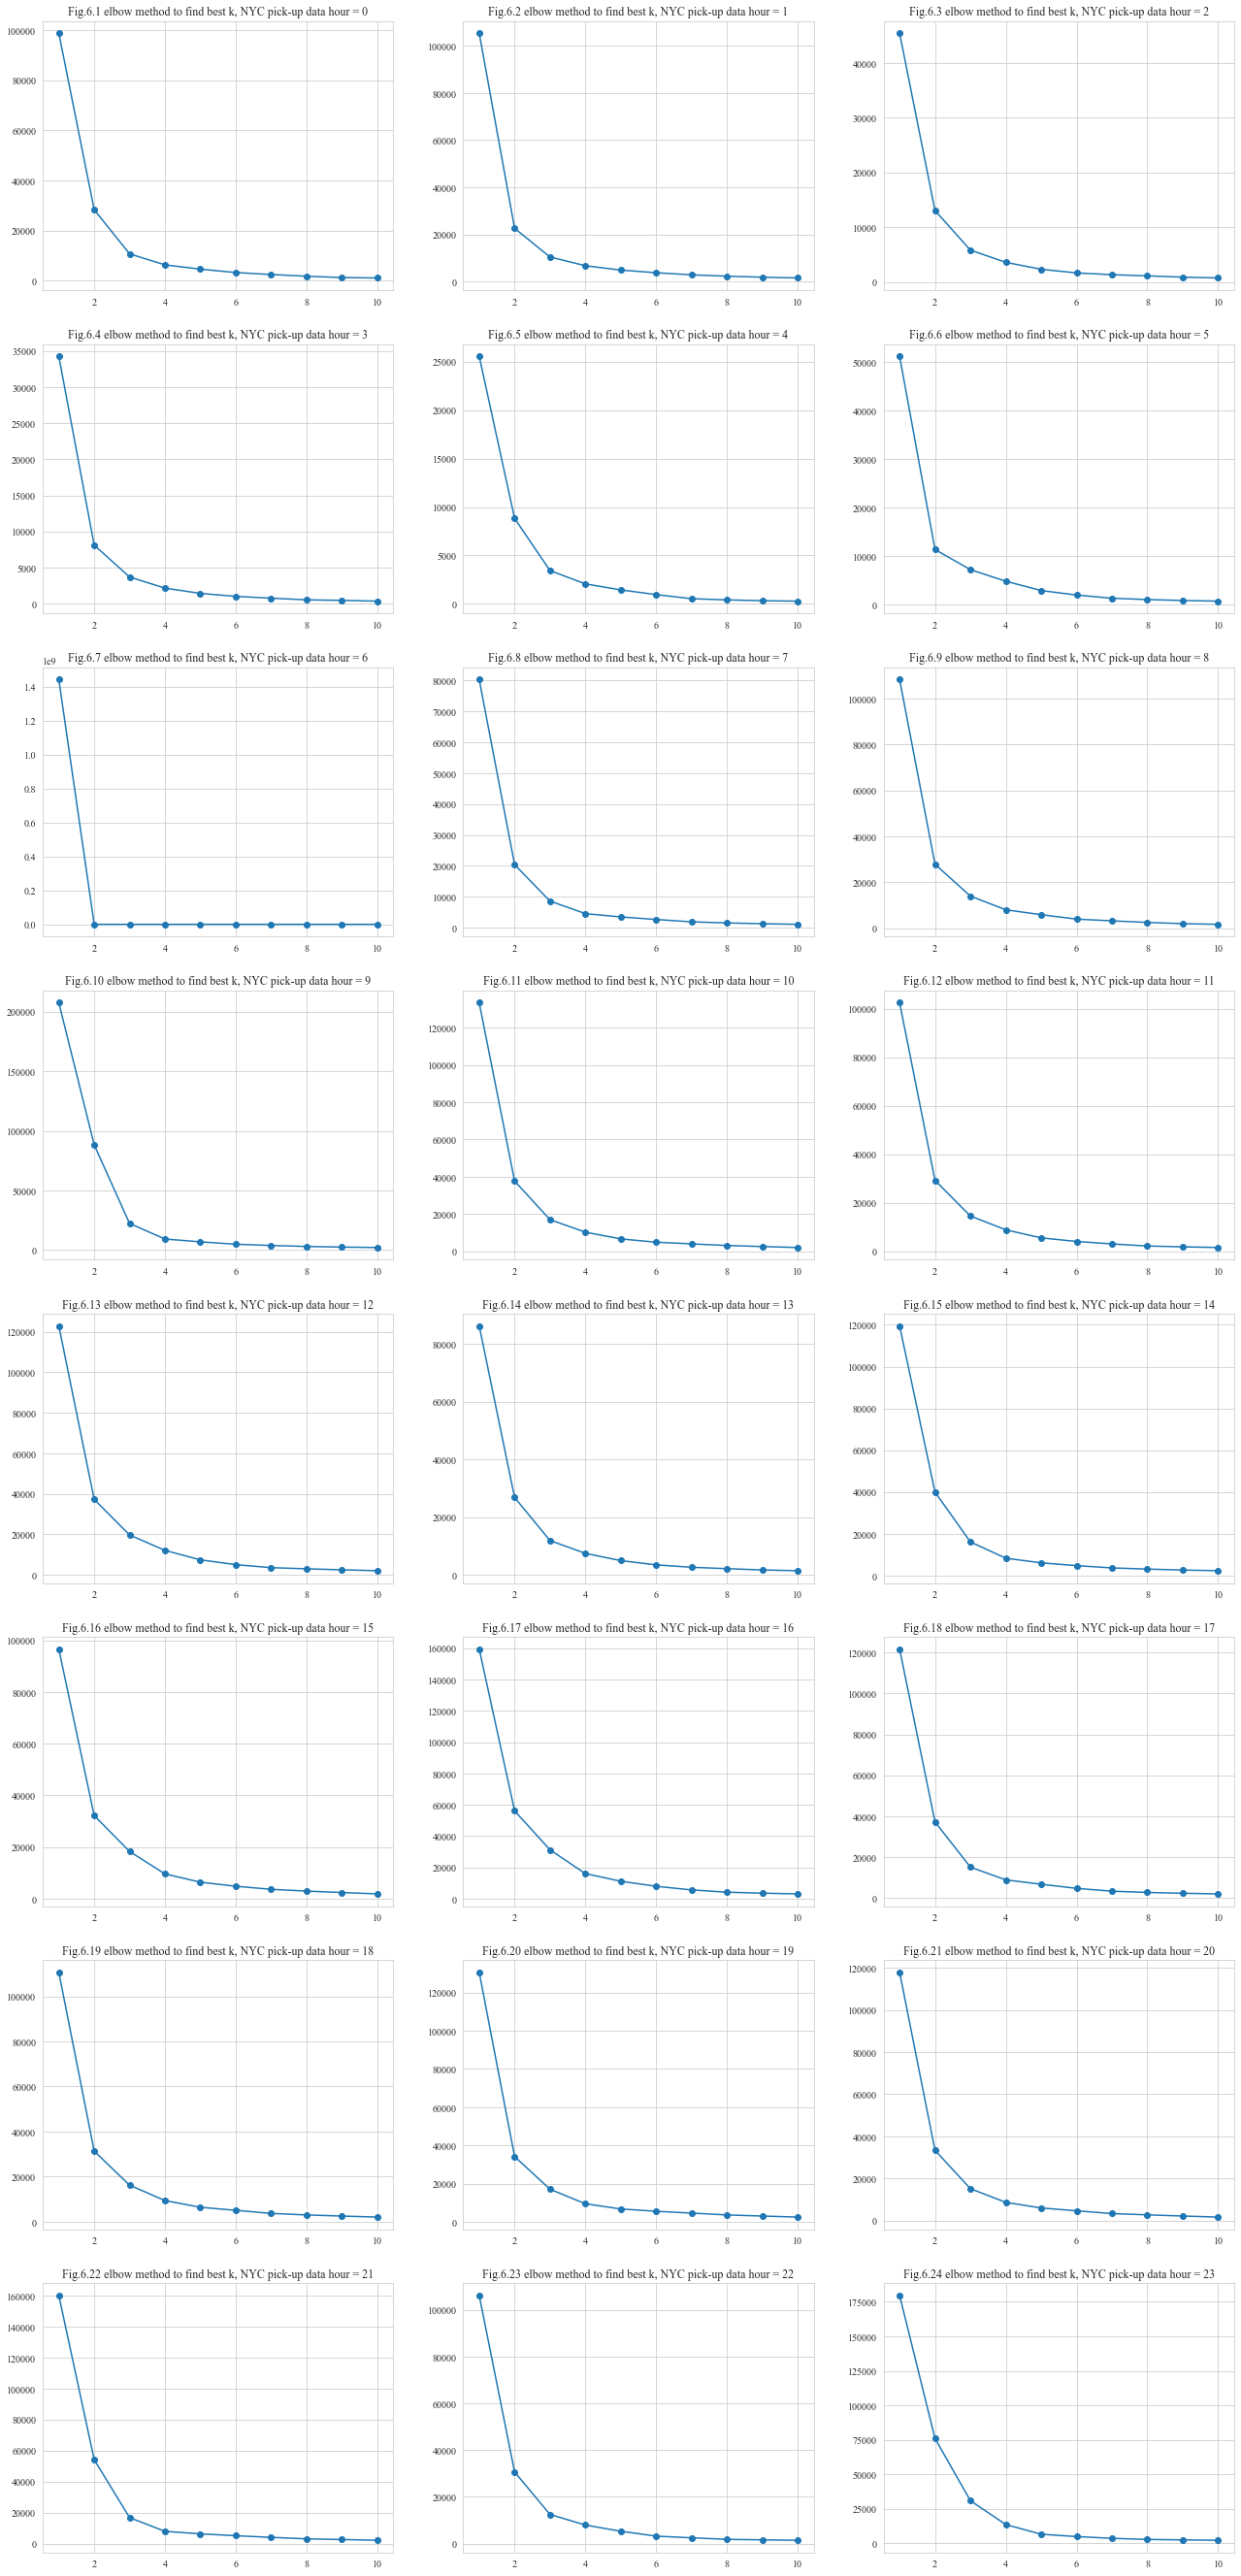

In [22]:
list_SSE_dropoff = []
# calculate SSE for a range of number of cluster

fig, ax = plt.subplots(8,3,figsize=(22,48))
for i in range(8):
    for j in range(3):
        kmean_inertia = []
        pickup_kmean = pickup_sum_bytime_ls[3*i+j][['mean_distance','mean_fare','mean_passenger_count']]
        for k in range(1,11):    
            pickup_kmean_result = KMeans(n_clusters=k, random_state=100).fit(pickup_kmean)
            kmean_inertia.append(pickup_kmean_result.inertia_)
    
        ax[i,j].plot(np.arange(1,11), kmean_inertia, marker='o', label='Pick up')
        ax[i,j].set_title(f'Fig.6.{3*i+j+1} elbow method to find best k, NYC pick-up data hour = {3*i+j}')

plt.show()

Fig. 6 shows that, for data in most of time, the elbow point is 3. K-means' result listed as Fig. 7:

In [23]:
best_k = [3 for x in range(24)]
best_k[5] = 2
best_k

[3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]

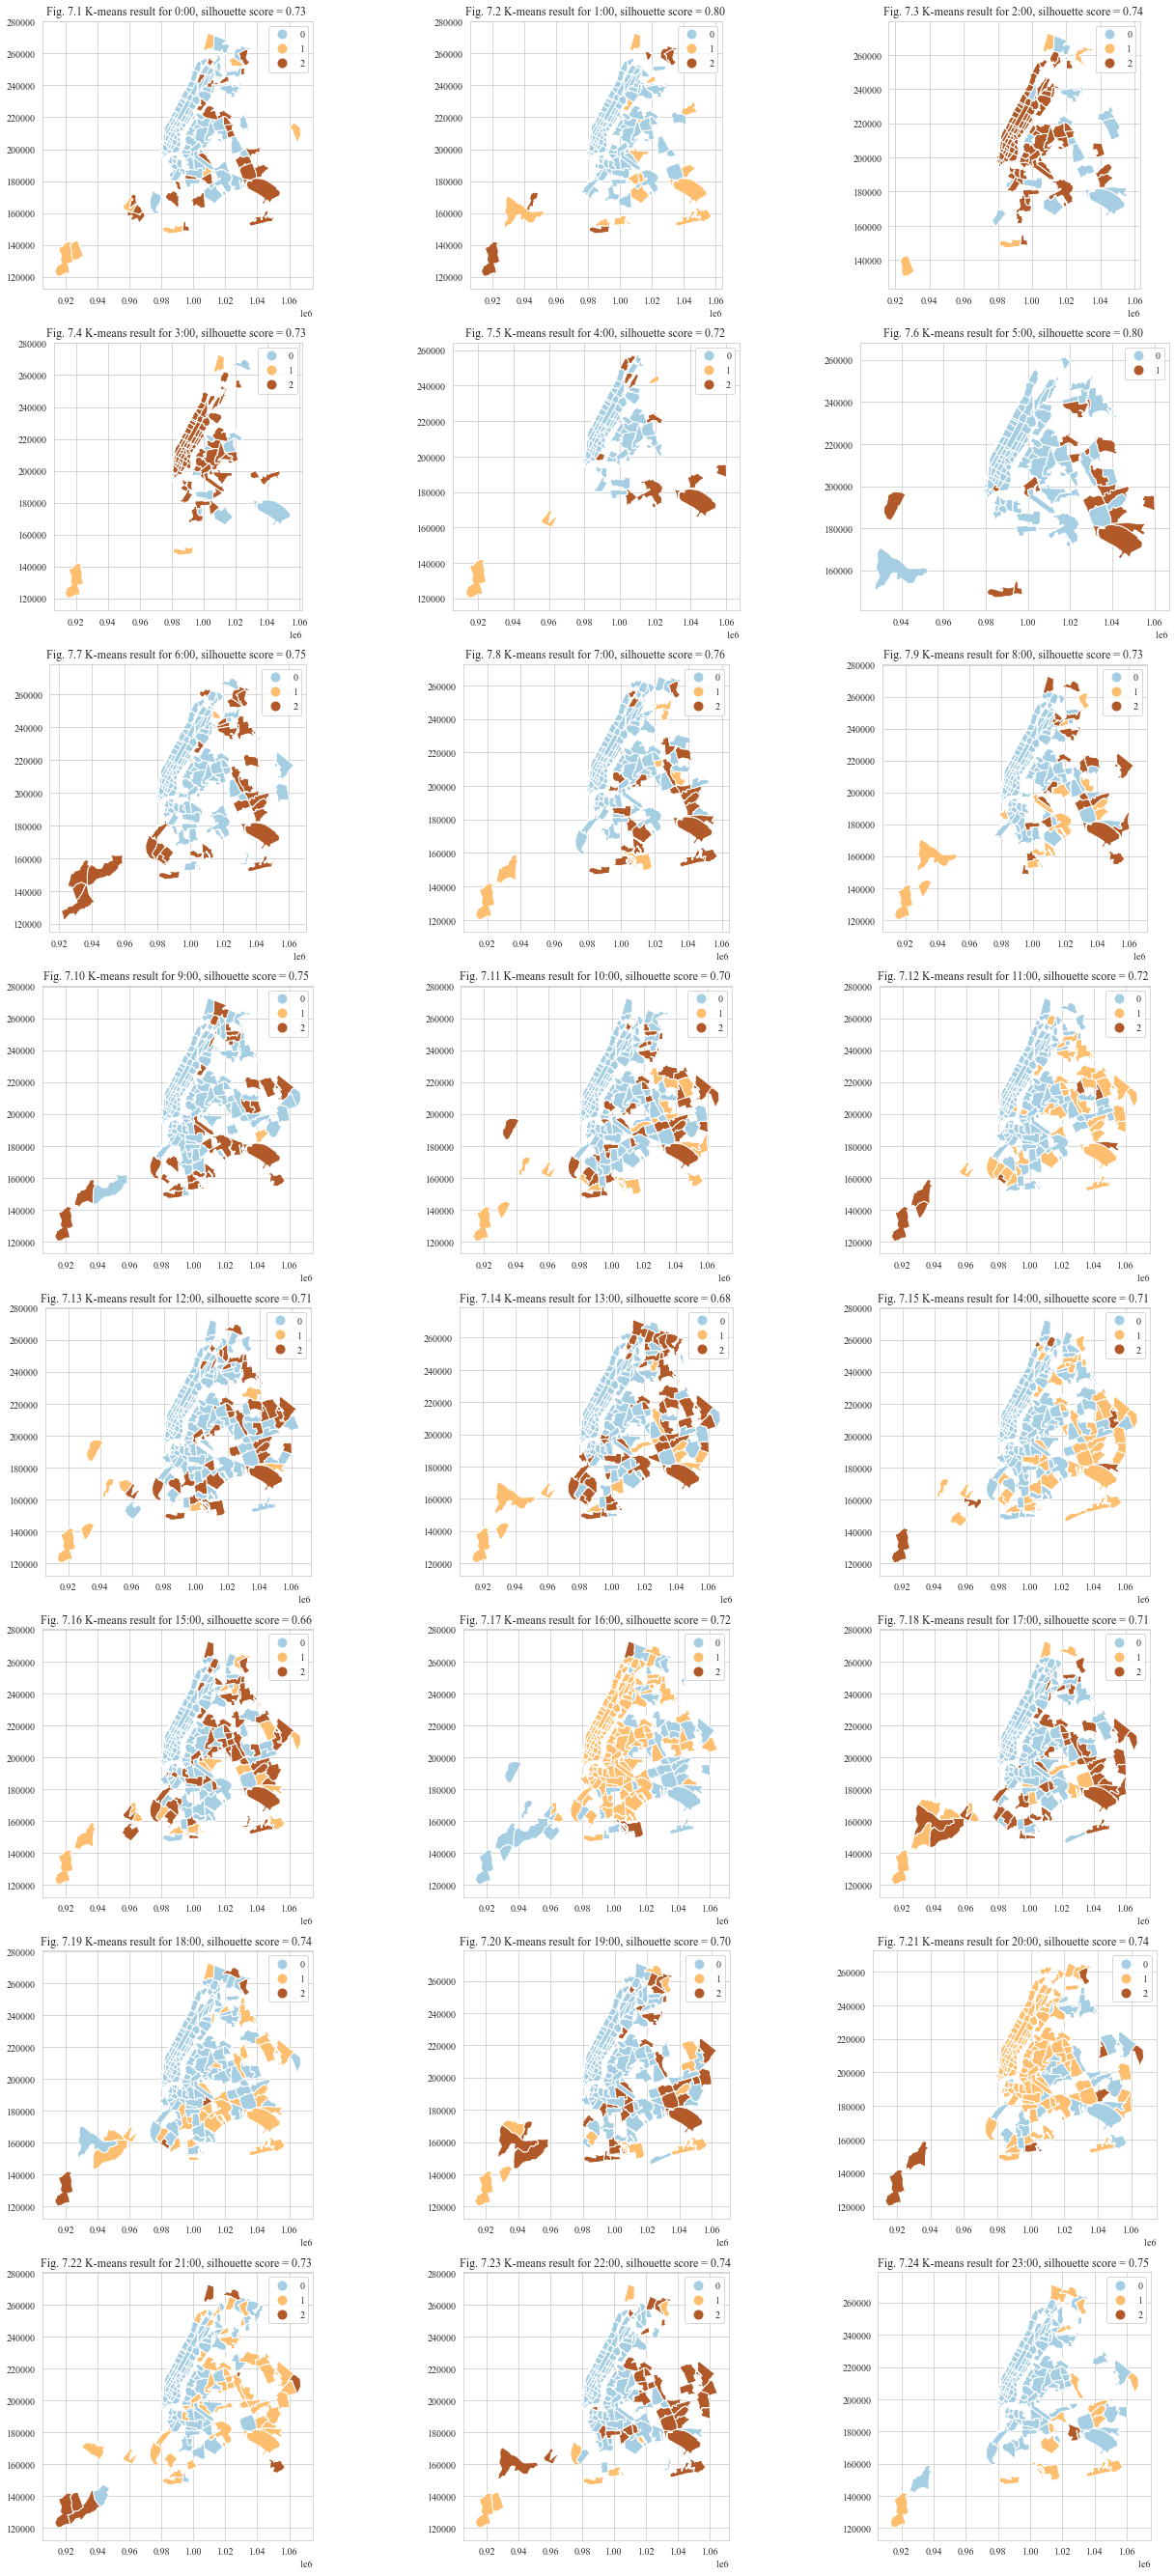

In [24]:
# k-means
fig, ax = plt.subplots(8,3,figsize=(22,48))
# We now have our DBSCAN object created, and we can extract the groups it has identified. We do this using the `.labels_` method.
kmeans_label = []
kmeans_gdf_ls = []
for i in range(8):
    for j in range(3):
        pickup_data = pickup_sum_bytime_ls[3*i+j][['mean_distance','mean_fare','mean_passenger_count']]
        kmeans_method = KMeans(n_clusters=best_k[3*i+j],random_state=750).fit(pickup_data)
        
        gdf = gpd.GeoDataFrame(pickup_sum_bytime_ls[3*i+j])
        cluster_nm = kmeans_method.labels_
        kmeans_label.append(cluster_nm)
        gdf['cluster_nm'] = cluster_nm
        kmeans_gdf_ls.append(gdf)
        gdf.plot(column='cluster_nm', categorical=True, legend=True, figsize=(12,8),ax=ax[i,j], cmap='Paired')
        ax[i,j].set_title(f'Fig. 7.{3*i+j+1} K-means result for {3*i+j}:00, silhouette score = {metrics.silhouette_score(pickup_data, cluster_nm):.02f} ')
    

In Fig. 7, the main cluster is still the Manhattan and its surrounding areas. Other clusters are usually located away from the centre area, such as airports. Silhouette's score in most situations is higher than 0.7, which shows that the clusters have clear boundaries. The K-means results are more reasonable and have a higher silhouette score than DBSCAN. That indicates K-means is more suitable for this clustering task.

Then a hierarchy clustering is exerted to summary the temporal similarity of K-means' result like Fig. 8:

In [25]:
# get labels matrix

labels_array = np.zeros((24,205))
for i in range(24):
    labels_array[i,:len(kmeans_label[i])] = kmeans_label[i]

In [26]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, leaf_rotation=90., **kwargs)

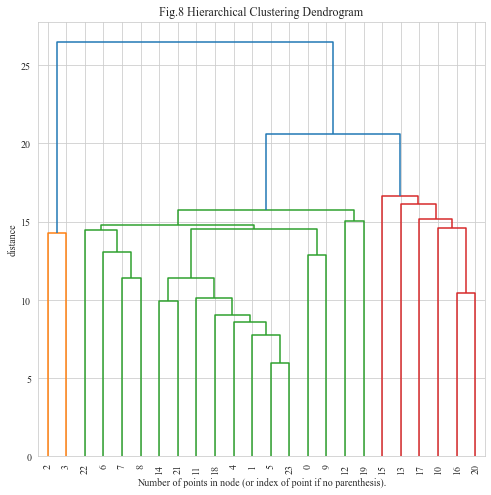

In [27]:
plt.figure(figsize=(8,8))

agg_cluster = AgglomerativeClustering(distance_threshold=0, n_clusters=None).fit(labels_array)
ax = plt.gca()
plt.title("Fig.8 Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(agg_cluster, truncate_mode="level")
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.ylabel('distance')
plt.show()

The hierarchical clustering shows three different clusters according to the time features. From 2 a.m. to 3 a.m., the orange cluster stands for a low-activity period; the red cluster stands for the time with more mobility activities (e.g. commuting, entertaining); and the green part is for the rest of the day.

### 6.3 Analysis of the clustering result
To understand what is the difference between three different clusters.

In [28]:
kmeans_gdf_ls[1].head()

zone_id  mean_distance  mean_passenger_count  mean_fare  count  \
0        4       4.818000              1.400000  23.100000      5   
0        7       3.516364              1.636364  16.431818     11   
0        8       5.900000              1.000000  73.700000      1   
0       10      15.820000              1.000000  58.060000      1   
0       12       3.070000              1.000000  15.800000      1   

                                            geometry  cluster_nm  
0  POLYGON ((992073.467 203714.076, 992068.667 20...           0  
0  POLYGON ((1010804.218 218919.641, 1011049.165 ...           0  
0  POLYGON ((1005482.276 221686.466, 1005304.898 ...           1  
0  POLYGON ((1044355.072 190734.321, 1044612.122 ...           1  
0  POLYGON ((979908.772 196066.565, 979980.852 19...           0

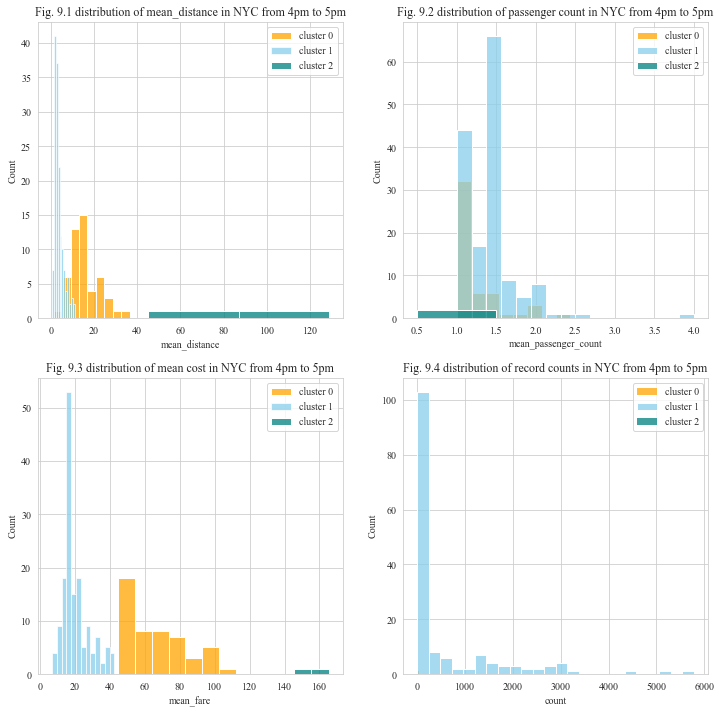

In [29]:
fig,ax = plt.subplots(2,2,figsize=(12,12))
plot_data = kmeans_gdf_ls[16].reset_index()
cluster0 = plot_data[plot_data['cluster_nm'] == 0]
cluster1 = plot_data[plot_data['cluster_nm'] == 1]
cluster2 = plot_data[plot_data['cluster_nm'] == 2]

sns.histplot(data=cluster0, x="mean_distance", color="orange", label="cluster 0", ax=ax[0,0])
sns.histplot(data=cluster1, x="mean_distance", color="skyblue", label="cluster 1", ax=ax[0,0])
sns.histplot(data=cluster2, x="mean_distance", color="teal", label="cluster 2", ax=ax[0,0])
ax[0,0].set_title('Fig. 9.1 distribution of mean_distance in NYC from 4pm to 5pm')
ax[0,0].legend()

sns.histplot(data=cluster0, x="mean_passenger_count", color="orange", label="cluster 0", ax=ax[0,1])
sns.histplot(data=cluster1, x="mean_passenger_count", color="skyblue", label="cluster 1", ax=ax[0,1])
sns.histplot(data=cluster2, x="mean_passenger_count", color="teal", label="cluster 2", ax=ax[0,1])
ax[0,1].set_title('Fig. 9.2 distribution of passenger count in NYC from 4pm to 5pm')
ax[0,1].legend()


sns.histplot(data=cluster0, x="mean_fare", color="orange", label="cluster 0", ax=ax[1,0])
sns.histplot(data=cluster1, x="mean_fare", color="skyblue", label="cluster 1", ax=ax[1,0])
sns.histplot(data=cluster2, x="mean_fare", color="teal", label="cluster 2", ax=ax[1,0])
ax[1,0].set_title('Fig. 9.3 distribution of mean cost in NYC from 4pm to 5pm')
ax[1,0].legend()


sns.histplot(data=cluster0, x="count", color="orange", label="cluster 0", ax=ax[1,1])
sns.histplot(data=cluster1, x="count", color="skyblue", label="cluster 1", ax=ax[1,1])
sns.histplot(data=cluster2, x="count", color="teal", label="cluster 2", ax=ax[1,1])
ax[1,1].set_title('Fig. 9.4 distribution of record counts in NYC from 4pm to 5pm')
ax[1,1].legend()

There is a clear difference between the 3 clusters in the mean distance and mean fare. From the Fig. 6, the pick-up points from 4 pm to 5 pm: cluster 1 is called **centre area**, it has the shortest average mileage and the least expense; these travel records are in the centre of NYC, which is around Manhattan and surrounding area.

cluster 0 can be recognized as **near-centre area**, it shows medium-level travelling distance and cost, and this cluster occupies the majority of remaining New York City's main urban areas, including some essential functional areas(e.g., airports).

cluster 2 is **near-suburb area**, which shows the furthest travelling distance and highest travel fare, and the minimum number of travel records. This area only has several places which are furthest from the centre area. 

In addition, the result also shows that distance from the centre area is positively correlated with the mean distance and mean fare. This phenomenon hints that the centre area may be the most popular travel destination.

The hierarchical clustering results show the similarity in the time domain to the results of spatial clustering. Looking back to Fig. 6, clustering of all time nodes keeps the centre area's basic range. However, the first cluster (only 2 and 3, orange cluster in Fig. 8) distributes the furthest areas from the centre to the near-centre and near-suburb parts. Cluster 2 (green cluster in Fig. 8) only divides areas furthest from the centre into near-suburb areas, and lots of lands in the main body of NYC are near-centre areas. Cluster 3 (red cluster in Fig. 8) mixes near-suburb and near-centre areas and cannot distinguish them from the map. The yellow cluster shows midnight records. At this time, the number of travel records reaches the valley for one day, and the only centre area has nighttime entertainment; the time range owned by the red cluster is the time with the most travel records, and people need to go to work/go home, so the spatial separation is blurred out; the green clustering result falls in somewhere between orange and red, which occupy citizens' rest time. At that time, people's travelling pattern shows clear geographic segmentation.

In [30]:
taxi_zone_with_pluto = taxi_zone_with_pluto.drop(columns=['geometry','index_right','OBJECTID','Shape_Leng','Shape_Area','zone','borough'])
# X = taxi_zone_with_pluto.iloc[:,4:-1]
# y = taxi_zone_with_pluto.iloc[:,2]

In [31]:
zone_dist_dummy = pd.get_dummies(taxi_zone_with_pluto['zonedist1_short'])
landuse_dummy = pd.get_dummies(taxi_zone_with_pluto['landuse'])

clf_data_origin = pd.concat([zone_dist_dummy,landuse_dummy,taxi_zone_with_pluto],axis=1)
clf_data = clf_data_origin.drop(columns=['longitude','latitude','zonedist1_short','landuse','zonedist1'])

In [32]:
clf_data.head()

B  C  M  P  R  1.0  2.0  3.0  4.0  5.0  6.0  7.0  8.0  9.0  10.0  11.0  \
0     0  1  0  0  0    0    1    0    0    0    0    0    0    0     0     0   
238   0  0  0  0  1    0    0    1    0    0    0    0    0    0     0     0   
1163  0  0  0  0  1    0    1    0    0    0    0    0    0    0     0     0   
2190  0  0  1  0  0    0    0    0    0    1    0    0    0    0     0     0   
2369  0  1  0  0  0    0    0    0    0    0    0    0    1    0     0     0   

      LocationID  
0            113  
238          113  
1163         113  
2190         113  
2369         113

In [33]:
pluto_fused = pd.DataFrame()
pluto_groupby_id = clf_data.groupby('LocationID')

for unit in pluto_groupby_id:
    tem_df = pd.DataFrame(np.zeros((1,len(clf_data.columns))),columns = clf_data.columns)
    for i in range(len(clf_data.columns)-1):
        if i < 16:
            tem_df.iloc[0,i] = unit[1][clf_data.columns[i]].sum()
    tem_df.iloc[0,-1] = unit[1].iloc[0,-1]
    pluto_fused = pluto_fused.append(tem_df)

In [34]:
used_result = kmeans_gdf_ls[20]
clf_used = used_result.merge(pluto_fused,how='inner',left_on='zone_id',right_on='LocationID')

clf_used = clf_used.drop(columns=['zone_id','mean_distance','mean_passenger_count','mean_fare','count','geometry'])

In [35]:
clf_used.head()

cluster_nm    B      C      M    P       R     1.0     2.0    3.0    4.0  \
0           1  0.0    7.0    3.0  3.0   597.0    11.0   218.0   71.0  153.0   
1           1  0.0  692.0  191.0  1.0  6570.0  2440.0  3269.0  108.0  870.0   
2           2  0.0   10.0    0.0  7.0  5224.0  4716.0   232.0    2.0   66.0   
3           2  0.0   21.0    6.0  8.0  7865.0  7227.0    51.0    5.0  168.0   
4           1  0.0    0.0    1.0  2.0     0.0     0.0     0.0    0.0    0.0   

     5.0    6.0   7.0   8.0   9.0  10.0   11.0  LocationID  
0   13.0    6.0   4.0  42.0  74.0   8.0   10.0         4.0  
1  313.0  134.0  39.0  68.0   5.0  98.0  110.0         7.0  
2   82.0    2.0  17.0  21.0   7.0  43.0   53.0         9.0  
3   70.0    9.0  37.0  66.0  13.0  42.0  212.0        10.0  
4    1.0    0.0   0.0   0.0   2.0   0.0    0.0        12.0

In [36]:
clf_used_group = clf_used.groupby(['cluster_nm'])
clf_data_origin['zonedist1_short'].value_counts()
zonedist_ls = []
landuse_ls = []
for unit in clf_used_group:
    zonedist1_sum_ls = []
    landuse_sum_ls = []
    for i in range(1,6):
        zonedist1_sum = unit[1].iloc[:,i].sum()        
        zonedist1_sum_ls.append(zonedist1_sum)
    for i in range(6,17):
        landuse_sum = unit[1].iloc[:,i].sum()
        landuse_sum_ls.append(landuse_sum)
    
    zonedist_ls.append(zonedist1_sum_ls)
    landuse_ls.append(landuse_sum_ls)

zonedist_ls_arr = np.array(zonedist_ls).transpose()
zonedist_ls_arr = zonedist_ls_arr / zonedist_ls_arr.sum(axis=0)[np.newaxis, :]


In [37]:
landuse_arr = np.array(landuse_ls).transpose()
landuse_arr = landuse_arr / landuse_arr.sum(axis=0)[np.newaxis, :]


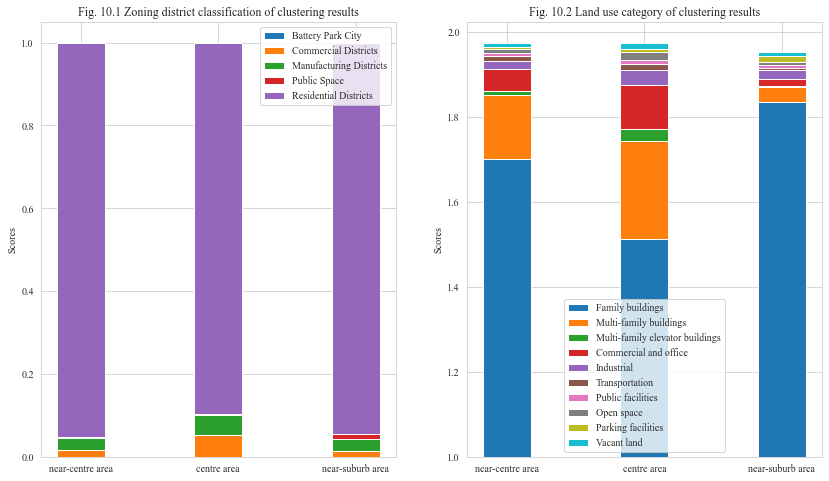

In [38]:
zonedist1_label = ['Battery Park City',
                    'Commercial Districts',
                    'Manufacturing Districts',
                    'Public Space',
                    'Residential Districts']
                    
landuse_label = ['Family buildings',
                'Multi-family buildings',
                'Multi-family elevator buildings',
                'Commercial and office',
                'Industrial',
                'Transportation',
                'Public facilities',
                'Open space',
                'Parking facilities',
                'Vacant land']
clusters_ls = ['near-centre area','centre area','near-suburb area']
fig, ax = plt.subplots(1,2,figsize=(14,8))

bottom = 0
for i in range(5):
    ax[0].bar(clusters_ls, zonedist_ls_arr[i,:], 0.35,bottom=bottom,label=zonedist1_label[i])
    bottom = bottom + zonedist_ls_arr[i,:]
ax[0].set_ylabel('Scores')
ax[0].set_title('Fig. 10.1 Zoning district classification of clustering results')
ax[0].legend()


for i in range(10):
    ax[1].bar(clusters_ls, landuse_arr[i,:], 0.35,bottom=bottom,label=landuse_label[i])
    bottom = bottom + landuse_arr[i,:]

ax[1].set_ylabel('Scores')
ax[1].set_title('Fig. 10.2 Land use category of clustering results')
ax[1].legend()
plt.show()

Fig. 10 shows the zoning district classification land-use situation of 3 clustering results. The central city has the highest percentage of commercial areas and the lowest percentage of residential areas, whereas the near-suburb area has more residential and open places. Near-centre area is more similar to the centre area, which has lots of commercial and industrial places. 

These three areas focus on different urban functions even though they have similar land use ratios:
1. The centrre area provides more work and consumer space.
2. The near-suburb area provides more housing.
3. The near-centre area is responsible for linking the two areas, providing more transportation, commercial places and housing.

Finally, combining the information provided by K-means (Fig. 6), hierarchical clustering (Fig. 8), and pick-up data summary in Fig.4, we can describe the three different travel patterns and their characters of land use function:

1. centre area: the centre area has lots of commercial places; lots of people need to work or relax. People in this place are prone to have a short-distance trip, and there are always most travel records in a day. 
2. near-centre area: near-centre area links the centre area and near-suburb area. It has many commercial and transportation places; there are also many commercial places. The travel pattern in this place is mainly medium-distance trips. Most of the travelling records are contributed by two airports. 
3. near-suburb area: this place has more family buildings. People in this place usually take long-distance trips, and almost all the data are concentrated during the commute and off-duty time. 

***
## 7. Conclusion
This article discusses three different travel patterns of urban dwellers by using clustering methods and discussing the land use behind the travel patterns. The main finding is that:

 The travel patterns for people in the centre area, near-centre area, and near-suburb area have apparent differences, and people at different times also show different travel patterns. 
 
 Plus, a hypothesis appears inspired by this experiment: the movement flow of individuals in the city tends to go to the centre area, and the frequency of travel decays with increasing distance, which is consistent with the spatial interaction model proposed by Michael Batty and Paul A. Longley (1994). However, further researches need to be done if we want to test this hypothesis.

There are still some limitations about this experiment:
1. the anonymized data reduce the precision of clustering analysis and hide some particular travel patterns of some individuals.

2. The interpretation of land use condition's distribution can be more profound.

Thus, more research need to be done to improve this article.

***
# Bibliography
1.	Akdag, F., Eick, C.F. and Chen, G. (2014) ‘Creating Polygon Models for Spatial Clusters’, in Andreasen, T. et al. (eds) Foundations of Intelligent Systems. Cham: Springer International Publishing (Lecture Notes in Computer Science), pp. 493–499. doi:10.1007/978-3-319-08326-1_50.

2.	Asakura, Y. and Iryo, T. (2007) ‘Analysis of tourist behaviour based on the tracking data collected using a mobile communication instrument’, Transportation Research Part A: Policy and Practice, 41(7), pp. 684–690. doi:10.1016/j.tra.2006.07.003.

3.	Batty, M., & Longley, P. A. (1994). Fractal cities: a geometry of form and function. Academic press.

4.	Cai, L. et al. (2018) ‘Design and Application of an Attractiveness Index for Urban Hotspots Based on GPS Trajectory Data’, IEEE Access, 6, pp. 55976–55985. doi:10.1109/ACCESS.2018.2869434.

5.	Chakrabarti, S. (2017) ‘How can public transit get people out of their cars? An analysis of transit mode choice for commute trips in Los Angeles’, Transport Policy, 54, pp. 80–89. doi:10.1016/j.tranpol.2016.11.005.

6.	Chen, J. et al. (2020) ‘Urban Hotspots Mining Based on Improved FDBSCAN Algorithm’, Journal of Physics: Conference Series, 1584(1), p. 012072. doi:10.1088/1742-6596/1584/1/012072.

7.	Chen, T. et al. (2020) ‘Exploring the homogeneity of theft offenders in spatio-temporal crime hotspots’, Crime Science, 9(1), p. 9. doi:10.1186/s40163-020-00115-8.

8.	Chu, K.-F., Lam, A.Y.S. and Li, V.O.K. (2020) ‘Deep Multi-Scale Convolutional LSTM Network for Travel Demand and Origin-Destination Predictions’, IEEE Transactions on Intelligent Transportation Systems, 21(8), pp. 3219–3232. doi:10.1109/TITS.2019.2924971.

9.	Chu, K.K.A. and Chapleau, R. (2010) ‘Augmenting Transit Trip Characterization and Travel Behavior Comprehension: Multiday Location-Stamped Smart Card Transactions’, Transportation Research Record: Journal of the Transportation Research Board, 2183(1), pp. 29–40. doi:10.3141/2183-04.

10.	Demissie, M.G. et al. (2021) ‘Modeling Location Choice of Taxi Drivers for Passenger Pickup Using GPS Data’, IEEE Intelligent Transportation Systems Magazine, 13(1), pp. 70–90. doi:10.1109/MITS.2020.3014099.

11.	Du, J. and Aultman-Hall, L. (2007) ‘Increasing the accuracy of trip rate information from passive multi-day GPS travel datasets: Automatic trip end identification issues’, Transportation Research Part A: Policy and Practice, 41(3), pp. 220–232. doi:10.1016/j.tra.2006.05.001.

12.	El Mahrsi, M.K. et al. (2017) ‘Clustering Smart Card Data for Urban Mobility Analysis’, IEEE Transactions on Intelligent Transportation Systems, 18(3), pp. 712–728. doi:10.1109/TITS.2016.2600515.

13.	Gao, S. et al. (2013) ‘Understanding Urban Traffic-Flow Characteristics: A Rethinking of Betweenness Centrality’, Environment and Planning B: Planning and Design, 40(1), pp. 135–153. doi:10.1068/b38141.

14.	Giannotti, F. et al. (2011) ‘Unveiling the complexity of human mobility by querying and mining massive trajectory data’, The VLDB Journal, 20(5), pp. 695–719. doi:10.1007/s00778-011-0244-8.

15.	Guo, D. et al. (2012) ‘Discovering Spatial Patterns in Origin-Destination Mobility Data: Discovering Spatial Patterns in Origin-Destination Mobility Data’, Transactions in GIS, 16(3), pp. 411–429. doi:10.1111/j.1467-9671.2012.01344.x.

16.	Guo, D., Liu, S. and Jin, H. (2010) ‘A graph-based approach to vehicle trajectory analysis’, Journal of Location Based Services, 4(3–4), pp. 183–199. doi:10.1080/17489725.2010.537449.

17.	Kitamura, R. (2001) ‘Urban Activity Patterns’, in International Encyclopedia of the Social & Behavioral Sciences. Elsevier, pp. 15995–15999. doi:10.1016/B0-08-043076-7/02594-8.

18.	Kumar, D. et al. (2016) ‘Understanding Urban Mobility via Taxi Trip Clustering’, in 2016 17th IEEE International Conference on Mobile Data Management (MDM). 2016 17th IEEE International Conference on Mobile Data Management (MDM), Porto: IEEE, pp. 318–324. doi:10.1109/MDM.2016.54.

19.	Lee, S.G. and Hickman, M. (2014) ‘Trip purpose inference using automated fare collection data’, Public Transport, 6(1–2), pp. 1–20. doi:10.1007/s12469-013-0077-5.

20.	Liu, Y. et al. (2021) ‘Identifying and understanding road-constrained areas of interest (AOIs) through spatiotemporal taxi GPS data: A case study in New York City’, Computers, Environment and Urban Systems, 86, p. 101592. doi:10.1016/j.compenvurbsys.2020.101592.

21.	Ma, X. et al. (2013) ‘Mining smart card data for transit riders’ travel patterns’, Transportation Research Part C: Emerging Technologies, 36, pp. 1–12. doi:10.1016/j.trc.2013.07.010.

22.	Mahadevia, D. and Advani, D. (2016) ‘Gender differentials in travel pattern – The case of a mid-sized city, Rajkot, India’, Transportation Research Part D: Transport and Environment, 44, pp. 292–302. doi:10.1016/j.trd.2016.01.002.

23.	Phithakkitnukoon, S. et al. (2010) ‘Taxi-Aware Map: Identifying and Predicting Vacant Taxis in the City’, in de Ruyter, B. et al. (eds) Ambient Intelligence. Berlin, Heidelberg: Springer Berlin Heidelberg (Lecture Notes in Computer Science), 
24.	pp. 86–95. doi:10.1007/978-3-642-16917-5_9.

25.	Ram, A. et al. (2010) ‘A Density Based Algorithm for Discovering Density Varied Clusters in Large Spatial Databases’, International Journal of Computer Applications, 3(6), pp. 1–4. doi:10.5120/739-1038.

26.	Shen, J. and Cheng, T. (2016) ‘A framework for identifying activity groups from individual space-time profiles’, International Journal of Geographical Information Science, 30(9), pp. 1785–1805. doi:10.1080/13658816.2016.1139119.

27.	Song, Y. et al. (2020) ‘MIFF: Human Mobility Extractions with Cellular Signaling Data under Spatio-temporal Uncertainty’, Proceedings of the ACM on Interactive, Mobile, Wearable and Ubiquitous Technologies, 4(4), pp. 1–19. doi:10.1145/3432238.

28.	Stopher, P., FitzGerald, C. and Zhang, J. (2008) ‘Search for a global positioning system device to measure person travel’, Transportation Research Part C: Emerging Technologies, 16(3), pp. 350–369. doi:10.1016/j.trc.2007.10.002.

29.	Tang, J. et al. (2015) ‘Uncovering urban human mobility from large scale taxi GPS data’, Physica A: Statistical Mechanics and its Applications, 438, pp. 140–153. doi:10.1016/j.physa.2015.06.032.

30.	Wang, H. et al. (2020) ‘Human Mobility Prediction Using Sparse Trajectory Data’, IEEE Transactions on Vehicular Technology, 69(9), pp. 10155–10166. doi:10.1109/TVT.2020.3002222.

31.	Wang, M., Wang, A. and Li, A. (2006) ‘Mining Spatial-temporal Clusters from Geo-databases’, in Li, X., Zaïane, O.R., and Li, Z. (eds) Advanced Data Mining and Applications. Berlin, Heidelberg: Springer Berlin Heidelberg (Lecture Notes in Computer Science), pp. 263–270. doi:10.1007/11811305_29.

32.	Wang, Y., Currim, F. and Ram, S. (2022) ‘Deep Learning of Spatiotemporal Patterns for Urban Mobility Prediction Using Big Data’, Information Systems Research, p. isre.2021.1072. doi:10.1287/isre.2021.1072.

33.	Xia, F. et al. (2018) ‘Exploring Human Mobility Patterns in Urban Scenarios: A Trajectory Data Perspective’, IEEE Communications Magazine, 56(3), pp. 142–149. doi:10.1109/MCOM.2018.1700242.

34.	Zhang, L. et al. (2016) ‘Exploiting Taxi Demand Hotspots Based on Vehicular Big Data Analytics’, in 2016 IEEE 84th Vehicular Technology Conference (VTC-Fall). 2016 IEEE 84th Vehicular Technology Conference (VTC-Fall), Montreal, QC, Canada: 
35.	IEEE, pp. 1–5. doi:10.1109/VTCFall.2016.7881010.

36.	Zhao, Z., Koutsopoulos, H.N. and Zhao, J. (2018) ‘Individual mobility prediction using transit smart card data’, Transportation Research Part C: Emerging Technologies, 89, pp. 19–34. doi:10.1016/j.trc.2018.01.022.

37.	Zheng, L. et al. (2018) ‘Spatial–temporal travel pattern mining using massive taxi trajectory data’, Physica A: Statistical Mechanics and its Applications, 501, pp. 24–41. doi:10.1016/j.physa.2018.02.064.



***
# Appendix
Appendix. A Land Use Categories details the relationship of building classes to land use categories.
|Code|Description|
|:---|:----------|
|01| One & Two Family Buildings|
|02| Multi-Family Walk-Up Buildings|
|03| Multi-Family Elevator Buildings|
|04| Mixed Residential & Commercial Buildings|
|05| Commercial & Office Buildings|
|06| Industrial & Manufacturing|
|07| Transportation & Utility|
|08| Public Facilities & Institutions|
|09| Open Space & Outdoor Recreation|
|10| Parking Facilities|
|11| Vacant Land|